# Creating a basic Cluster Expansion

In [1]:
import numpy as np
import json
from monty.serialization import loadfn, dumpfn
from pymatgen.core.structure import Structure
from smol.cofe import ClusterExpansion, StructureWrangler, \
    RegressionData
from smol.cofe.extern import EwaldTerm
from smol.io import load_work, save_work
from theorytoolkit.optimization.ce_sparse_opt import *

# Load a cluster expansion file from previous saved one

In [2]:
work = load_work('../data/lmto_indicator.json')
for name, obj in work.items():
    print(f'{name}: {type(obj)}\n')

StructureWrangler: <class 'smol.cofe.wrangling.wrangler.StructureWrangler'>



In [3]:
wrangler = work['StructureWrangler']

#  Training part

Training a cluster expansion is one of the most critical steps. This is how you get **effective cluster interactions (ECI's)**. Here we show two simple example to apply typical $\ell_1$ regularized regression and $\ell_0\ell_1$ regularized regression with mixed integer qudraptic programming with `gurobi` pakage.

In `smol` the coefficients from the fit are not exactly the ECI's but the ECI times the multiplicity of their orbit.

# Optimization of $\ell_1$ regularization in Li-Mn-Ti-O system

In [4]:
coefs_l1 = l1_optimize(A=wrangler.feature_matrix, 
                   f= wrangler.get_property_vector('total_energy'), 
                   mu = 1e-4)

print(coefs_l1)

[-12.13517268  -3.82446178  -2.01972243   1.89679575   1.24721834
  -0.01437917   0.75156937  -0.39776006   0.18292662   0.56033911
   0.02660087  -0.30362049   0.37305809   0.02952346  -0.10023389
   0.35345145  -0.39812598  -0.02524803   0.18692421  -2.72119993
  -0.55522068   1.03001267  -0.12110085   0.81454395   0.57350035
  -0.91274639  -0.26928441]


# Optimization of $\ell_1\ell_0$ regularization in Li-Mn-Ti-O system

In [5]:
coefs_l0l1 = l0l1_optimize(
    A=wrangler.feature_matrix, 
    f=wrangler.get_property_vector('total_energy'), 
    mu1=1e-4, mu0=1e-3)

print(coefs_l0l1)

Restricted license - for non-production use only - expires 2022-01-13
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter PSDTol to 1e-05
   Prev: 1e-06  Min: 0.0  Max: inf  Default: 1e-06
[-1.03648403e+01 -7.34620337e+00  0.00000000e+00  1.86403110e+00
  5.49912331e-01 -1.51873893e-01  7.48583619e-01 -4.13430536e-01
  1.85496663e-01  5.53551410e-01 -6.16997772e-15 -2.87484027e-01
  3.70806863e-01  2.96464242e-15 -1.06770779e-01  3.51162508e-01
 -4.05146941e-01 -6.58327559e-15  2.05584933e-01 -1.93129274e+00
  0.00000000e+00  7.23583425e-01 -1.25808411e-01  5.11422847e-01
  1.76593585e-01 -7.23372819e-01  0.00000000e+00]


# Comparison of $\ell_1$ and $\ell_1\ell_0$ in Li-Mn-Ti-O system

Non-zero ECIs in L1:  27
Non-zero ECIs in L0L1:  21


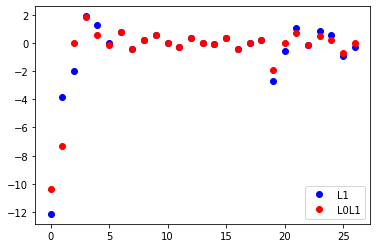

In [6]:
plt.plot(coefs_l1, 'o', color = 'b',label = 'L1')
plt.plot(coefs_l0l1, 'o',color = 'r', label = 'L0L1')
plt.legend()


print("Non-zero ECIs in L1: ", np.sum(np.abs(coefs_l1)>1e-6))
print("Non-zero ECIs in L0L1: ", np.sum(np.abs(coefs_l0l1)>1e-6))

### 4) The cluster expansion
Now we can use the above work to create the `ClusterExpansion`. The cluster expansion can be used to predict the fitted property for new structures, either for testing quality or for simulations such as in Monte Carlo.
Note that when using the `predict` function, the cluster expansion will have to match the given structure if it has not seen it before.

In [7]:
reg_data = RegressionData.from_object(
    l0l1_optimize, feature_matrix=wrangler.feature_matrix,
    property_vector=wrangler.get_property_vector('total_energy'),
    parameters={'mu1': 1e-4, 'mu0': 1e-3})
expansion = ClusterExpansion(
    wrangler.cluster_subspace, coefficients=coefs_l0l1,
    regression_data=reg_data)

structure = np.random.choice(wrangler.structures)
prediction = expansion.predict(structure, normalize=True)

print(f'The predicted energy for a structure with composition '
      f'{structure.composition} is {prediction} eV/prim.\n')
print(f'The fitted coefficients are:\n{expansion.coefs}\n')
print(f'The effective cluster interactions are:\n{expansion.eci}\n')
print(expansion)

The predicted energy for a structure with composition Li+22 Mn3+6 Ti4+8 O2-36 is -13.686013032304896 eV/prim.

The fitted coefficients are:
[-1.03648403e+01 -7.34620337e+00  0.00000000e+00  1.86403110e+00
  5.49912331e-01 -1.51873893e-01  7.48583619e-01 -4.13430536e-01
  1.85496663e-01  5.53551410e-01 -6.16997772e-15 -2.87484027e-01
  3.70806863e-01  2.96464242e-15 -1.06770779e-01  3.51162508e-01
 -4.05146941e-01 -6.58327559e-15  2.05584933e-01 -1.93129274e+00
  0.00000000e+00  7.23583425e-01 -1.25808411e-01  5.11422847e-01
  1.76593585e-01 -7.23372819e-01  0.00000000e+00]

The effective cluster interactions are:
[-1.03648403e+01 -7.34620337e+00  0.00000000e+00  3.10671850e-01
  4.58260276e-02 -2.53123155e-02  2.49527873e-01 -6.89050893e-02
  6.18322211e-02  4.61292842e-02 -2.57082405e-16 -2.39570022e-02
  6.18011439e-02  2.47053535e-16 -1.77951298e-02  2.92635423e-02
 -1.68811226e-02 -5.48606299e-16  2.56981167e-02 -8.04705309e-02
  0.00000000e+00  9.04479281e-02 -6.29042057e-02  6.39

/tmp/ipykernel_297766/2761161619.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  structure = np.random.choice(wrangler.structures)
